# Formula 1 Intial Classification Modelling on the complete dataset
Author : Ben Palmer\
Date : 02/11/2022

## Summary:

In summary we can see that manual feature selection performed the best on the with the vanilla logisitic regression model. 

|    | Dimension Reduction Technique      | Target   |  Accuracy|     
|---:|:-----------------------------------|:---------|---------:|
|  0 | Manual Feature Selection           | Position | 0.59     |    
|  1 | Manual Feature Selection           | LapDelta | 0.61     | 
|  2 | PCA                                | Position | 0.34     |     
|  3 | PCA                                | LapDelta | 0.38     | 
|  4 | Automatic Feature Selection        | Position | 0.57     |     
|  5 | Automatic Feature Selection        | LapDelta | 0.54     | 

The PCA dimension reduction performed worse with the most miss clasification. It performed especailly poorly on Qualifying position. This may be because it is missing the variance for the top driver and teams dummy encoded variables and hence losing important features. This features may be espeically important for Qualifying position because often one team or a few teams are dominant at any one time and hence are often at the front. 

Automatic feature selection can not improve on manual feature selection, in addittion in this test it uses the Fastest Sector time which is a break down of the target. Hence if automatic feature selection was to be taken forward these features would need to be removed. However, since it does not perform any better than manual feature selection. Going forward the next model iteration will soley focus on manual feature selection

## Introduction:
The aim of this notebook is to download from FastF1 all the telmetry data from 2018 to present and run the feature aggregations to create the complete database of driver record feature set. Run a quick data analysis to see the variance of the features and prepare the data for modelling.

As seen in the notebook [5_Forumla1_Feature_Importance](./5_Forumla1_Feature_Importance.ipynb), the techniques of Random Forest, Select K Best and PCA pick up on different important features. The plan for modelling is to test two different approaches:
- Manual Feature selection, selecting the important features from Random Forest and Select K Best
- Using PCA as dimension reduction.

As a reminder dimension is very important for this dataset as the data is relatively small only 1900 records, therefore high dimensionality in the data can lead to over fitting and reduce the predictive power of the model on the test set. We will try to avoid that be reducing the dimensions.

This notebook will build initial models to evaluate the initial feature importance of a number of techniques and discuss the best approach of PCA vs Manual feature selection

### Model prediction:
The target variables for this project are `Qualifying Position` and `Qualifying Lap Time`. For lap time since it is highly affected by the length of the circuit, the lap time prediction will be a delta between the drivers time and the fastest time. Therefore removing the effects of the circuit length and characteristics on the lap time. 

The position is not a pure continous variable it is ranked result, close to classification with bin size of 1. It is also expected prediction the lap time deltas as a regression would be challenging because of the variability. Therefore this notebook will evaluate classification modeling techniques by binning the target variables. As per the previous notebook quartile bins will be used to ensure that the classes are evenly weighted with now bais. 


## Table of Contents:

1. [Data Collection and Feature Engineering](#collect)\
 1.1 [Data Dictionary](#datadict)\
 1.2 [Load the data](#load)

2. [EDA on the Aggregated Data](#eda)

3. [Prepare data for Modelling](#prep)\
    3.1 [Column transformer](#col)\
    3.2 [Target variable](#target)

4. [Feature Importance](#featureimportanec)\
    4.1 [Random Forest](#rf)\
    4.2 [Select K best](#sk)\
    4.3 [Principal Component Analysis](#pca)\
    4.4 [Comparison](#compare)

5. [Logisitic Regression Classification](#logreg)\
    5.1 [Manual Feature Selection](#manual)\
    5.2 [Principal Component Analysis](#pca2)\
    5.3 [Automatic Feature Selection](#auto)

6. [Summary](#sum)

7. [Next Steps](#nextsteps)

8. [Appendix](#appendix)



### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, plot_roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score)
import joblib

# Data collection and feature engineering:
<a id="collect"></a>
This function runs the data collection for all the GrandPrix's from 2018 to present day. Since that is a large amount of telemetry data it can't be held in memory, so the function runs the feature aggregations functions developed in [4_Formula1_telemetrydata_aggregation](./4_Formula1_telemetrydata_aggregation.ipynb) on the fly and stores the feature results for each each driver, for every GrandPrix.

This API call takes approximately 7 hours to run. This does not need to be run as the output dataframe has been saved and the intermediate product can be loaded for ease.

In [ ]:
#warning this takes 287 minutes to run!!!
# thats over 6 hours
# file='./data/clean/combined_ergast_clean.csv'
# qualify_df=pull_clean_aggregate_telemetry(file)

In [96]:
# save the dataframe
#qualify_df.to_pickle('./data/model_data/formula1_complete_2018_2022_updated_301022.pkl',compression='gzip')

## Data Dictionary:
<a id="datadict"></a>
As described in [4_Formula1_telemetrydata_aggregation](./4_Formula1_telemetrydata_aggregation.ipynb), the data from all the laps and telemetry per lap is aggregated by engineering a series of features to capture all the data. These features try to capture the characteristics of the **circuit**,**car** and **driver**. The data dictionary of all the features generated is as follows:

- `raceId`: unique id number for each GrandPrix
- `driverRef`: Driver Name 
- `number`: Unique number chosen by the drivers for numbering the car they drive in
- `name`: GrandPrix name
- `circuitRef` : Circuit reference 
- `country` : Country of circuit
- `nationality_drivers`: Nationality of Drivers- assigned as a country same format as circuit 
- `constructorRef`: Team name reference 
- `nationality_constructors`: Nationality of the Team
- `year`: Year of the Grand Prix 
- `lat_x`: Laitude of the Grand Prix
- `lng_x` : Longitude of the Grand Prix 
- `alt`: Alitude of the circuit 
- `quali_position` : Qualifying Position **Target Variable** 
- `dob` driver date of birth
- `fastest_lap_milliseconds` : Fastest Lap time in milliseconds - this is calculated by moving the Q1 (qualifying1) times of the last 5 drivers to Q3 (qualifying 3 session), and the Q2 (qualifying 2) times of the drivers 10-15 to Q3. In formula 1 the qualifying session is broken down into 3 sessions. In each session the drivers set out to do there fastest times. In Qualifying 1 the bottom 5 are knocked out, in Qualifying 2 the next bottom 5. Leaving the top ten to fight it out for the order of the top ten races for the race. However it was found that some drivers who make it in to the top ten shoot out perform worse than they did in qualifying2, this can impact the prediction
- `fastest_all_sessions_milliseconds` - Fastest lap time in milliseconds **Target Variable** - to avoid the issue above the fastest lap time for each driver across all sessions was taken as the target variable
- `circuit_length` - length of circuit in (m)
- `circuit_total_straight` -total length of straights in the lap (m)
- `circuit_mean_straight` - mean length of straights in the lap (m)
- `circuit_max_straight` - max length of straight in the lap (m)
- `circuit_total_corner_length` - total length of all the corners in the lap (m)
- `circuit_mean_corner_length` - mean corner length (m)
- `circuit_max_corner_length` - max corner length (m)
- `circuit_total_corner_curvature` - sum of corners curvature found as average of second derivative for that corner
- `circuit_mean_corner_curvature` - mean corner curvature as average of second derivative for each corner
- `circuit_max_corner_curvature` - max corner curvature 
- `circuit_std_corner_curvature` - variance of corner curvature
- `circuit_number_of_corners` - number of corners in the circuit
- `max_max_speed` - top speed of all the laps by the driver (km/h)
- `max_fastest_lap_speed` - top speed on the fastest lap by the driver (km/h)
- `var_fastest_lap_speed` - variance in fastest lap speed 
- `min_fastest_lap_speed` - minimum of fastest lap speed (km/h)
- `max_lap_speed` -average max lap speed over all the laps in qualifying (km/h)
- `var_lap_speed` - variance in lap speed over all the laps in qualifying
- `bottom_lap_speed` - average bottom speed in the lap over all the laps in qualifying(km/h)
- `mean_straight_speed`- average straight speed over all the laps (km/h)
- `var_straight_speed` - variance in straight speed over all the laps 
- `max_fastest_accleration`- m/s2 maximum accleration on the fastest lap
- `var_fastest_accleration` - variance in accleration on the fastest lap
- `min_fastest_accleration`- minimum accleration on the fastest lap
- `mean_max_lap_accleration`- mean fastest lap accleration
- `mean_var_lap_accleration` - average variance in lap accleration over all the laps
- `mean_min_lap_accleration` - average minimum lapp accleration over all the laps
- `max_fastest_lap_rpm` - maximum rpm on the fastest lap
- `var_fastest_lap_straight_rpm`- variance in the fastest lap rpm on the straight
- `mean_fastest_lap_straight_rpm` - average fastest lap rpm on the straight
- `max_max_rpm` - maximum rpm on the fastest lap
- `mean_var_straight_rpm` - average variance in rpm on the straight over all the laps
- `mean_straight_rpm` - mean engine rpm over all teh alps
- `avg_gear1_time` - avg gear 1 time over all laps
- `avg_gear2_time`- avg gear 2 time over all laps
- `avg_gear3_time` - avg gear 3 time over all laps
- `avg_gear4_time` - avg gear 4 time over all laps
- `avg_gear5_time` - avg gear 5 time over all laps
- `avg_gear6_time` - avg gear 6 time over all laps
- `avg_gear7_time` - avg gear 7 time over all laps
- `avg_gear8_time` - avg gear 8 time over all laps
- `avg_gear1_time_fl`- avg gear 1 time on the fastest lap
- `avg_gear2_time_fl` - avg gear 2 time on the fastest lap
- `avg_gear3_time_fl` - avg gear 3 time on the fastest lap
- `avg_gear4_time_fl`- avg gear 4 time on the fastest lap
- `avg_gear5_time_fl`- avg gear 5 time on the fastest lap
- `avg_gear6_time_fl`- avg gear 6 time on the fastest lap
- `avg_gear7_time_fl`- avg gear 7 time on the fastest lap
- `avg_gear8_time_fl`- avg gear 8 time on the fastest lap
- `avg_lap_time_on_brake`- avg lap time the driver is on the brake over all laps (s)
- `avg_lap_distance_on_brake` - avg lap distance the driver travels on the brake over all laps (m)
- `avg_lap_time_on_DRS` - avg lap time the driver has the rear wing flap (DRS) open (s)
- `avg_lap_distance_on_DRS` - avg lap distane the driver has the rear wing flap (DRS) open (m)
- `avg_lap_bottom_speed_corner` - avg lap bottom speed in the corner over all the laps (km/h)
- `avg_lap_max_speed_corner` - maximum speed in the corners average over all laps (km/h)
- `avg_lap_bottom_speed_tightest_corner` - speed in the tightest corner averaged over all the laps (km/h)
- `fl_lap_time_on_brake` - Fastest lap time the driver is on the brake (s)
- `fl_lap_distance_on_brake` - fastest lap distance the driver is on the brake (m)
- `fl_lap_time_on_DRS` - fastest lap time the driver has the rear wing open (s)
- `fl_lap_distance_on_DRS` - fastest lap distance the driver travels with rear wing open (s)
- `fl_lap_bottom_speed_corner`- average bottom speed in the corners on the fastest lap
- `fl_lap_max_speed_corner` - maximum speed in the corners on the fastest lap (km/h)
- `fl_lap_bottom_speed_tightest_corner` - minimum speed in the tightest corner on the fastest lap
- `fl_tyre` - tyre the driver was on the fastest lap
- `fl_tyre_life` - how many laps have been completed on this tyre prior to this lap on the fastest lap
- `fastestlap_Sector1` - sector 1 time for the fastest lap (s)
- `fastestlap_Sector2` - sector 2 time for the fastest lap (s)
- `fastestlap_Sector3` - sector 3 time for the fastest lap (s)
- `avglap_Sector1` - average lap time in sector 1 (s)
- `avglap_Sector2` - average lap time in sector 2 (s)
- `avglap_Sector3` - average lap time in sector 3 (s)
- `fastestlap_percentagerainfall` - amount of rain fall on the fastest lap 
- `fastestlap_track_temperature` - temperature of the track of the fastest lap (celcius)
- `fastestlap_humidity` - humidity of the fastest lap
- `avg_lap_percentagerainfall` - average of all the laps amount of rainfall
- `avg_lap_track_temperature'` -average track temperature over all the laps
- `avg_lap_humidty` - average humidity over all the laps
- `age` - age of the driver (year - dob)


## Load the downloaded data:
<a id="load"></a>
This data was download from the first interation of the script, where it kept the NaN rows during download and aggregation. These were caused by that driver not recording any telemetry data for that lap. In future update of the script these NaN rows are cleaned out during the process. However to show the insights of who has the most NaN rows we will load an earlier version:

In [2]:
qualify_df_1=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_update291022.pkl',compression='gzip')

In [98]:
print(f'The complete database has this many nan rows {qualify_df_1.isna().any(axis=1).sum()}')
print(f'The nans are {round(qualify_df_1.isna().any(axis=1).sum()/len(qualify_df_1),2)}% of the data')

The complete database has this many nan rows 46
The nans are 0.02% of the data


These nans come from lack of car telemetry data. Who has the most Nan's?

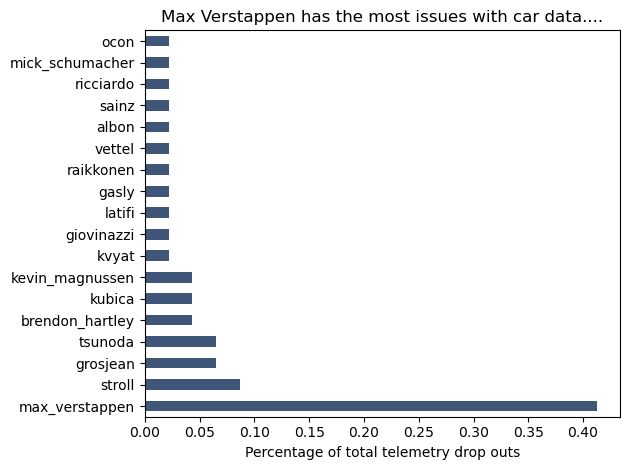

In [4]:
per_nan = qualify_df_1.loc[(qualify_df_1.isna().any(axis=1)),'driverRef'].value_counts()/len(qualify_df.loc[(qualify_df.isna().any(axis=1))])
plt.figure()
per_nan.plot(kind='barh')
plt.title('Max Verstappen has the most issues with car data....')
plt.xlabel('Percentage of total telemetry drop outs')
plt.tight_layout()
plt.savefig('./images/verstappend_nans.jpg',dpi=300)
plt.show()

Max Verstappen has by far the most NaN rows than any other driver, these all come from races where his telemetry data was not working. This is interesting as the other Red Bull driver did not have the same problem, therefore it can be hypothesised this isnt an issue with Red Bull sharing the data but specifically with Max Verstappen. Since he is one of the main protagonist in the years 2018 to 2022 it is easy to see how it would benefit him if he didnt share his data with the public F1 Live database as this could allow other teams to spy on his techniques and car performance. Therefore it does not take a big step to see that Max's team saw it as a competitive advantage to not share his telemetry data for certain GrandPrix's. It would be very intersting to investigate this further.

### Load the data:

As mention above the data download was re run after a script update which does not save the NaN rows, the output of this download has been saved and can be loaded:

In [12]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_complete_301022.pkl',compression='gzip')

In [13]:
print(f'The complete database has this many nan rows {qualify_df.isna().any(axis=1).sum()}')
print(f'The nans are {round(qualify_df.isna().any(axis=1).sum()/len(qualify_df),2)}% of the data')

The complete database has this many nan rows 0
The nans are 0.0% of the data


In [14]:
qualifying_df=qualify_df.copy()

## Intial EDA of the complete feature aggregated dataset:
<a id="eda"></a>

Firstly lets inspect the data and the features, to see which ones show variability with the target variable. Plus how the features are distributed.

To do that we will create a copy of the dataframe soley to explore the features:

In [3]:
display_df=qualify_df.copy()
display_df.dropna(inplace=True)

In [4]:
# This function converts numberical columns wrongly assigned as objects to floats
display_df = convert_object_to_float(display_df)

In [5]:
#This function generates the target features and bins the continous variables to be used as categorical variables for classification prediction
display_df = engineer_target_bin(display_df)

This plots the categorical features as bars coloured by the bins of the target variables. For this plot we are looking at the relationship between the categorical variables and the bins of qualifying position

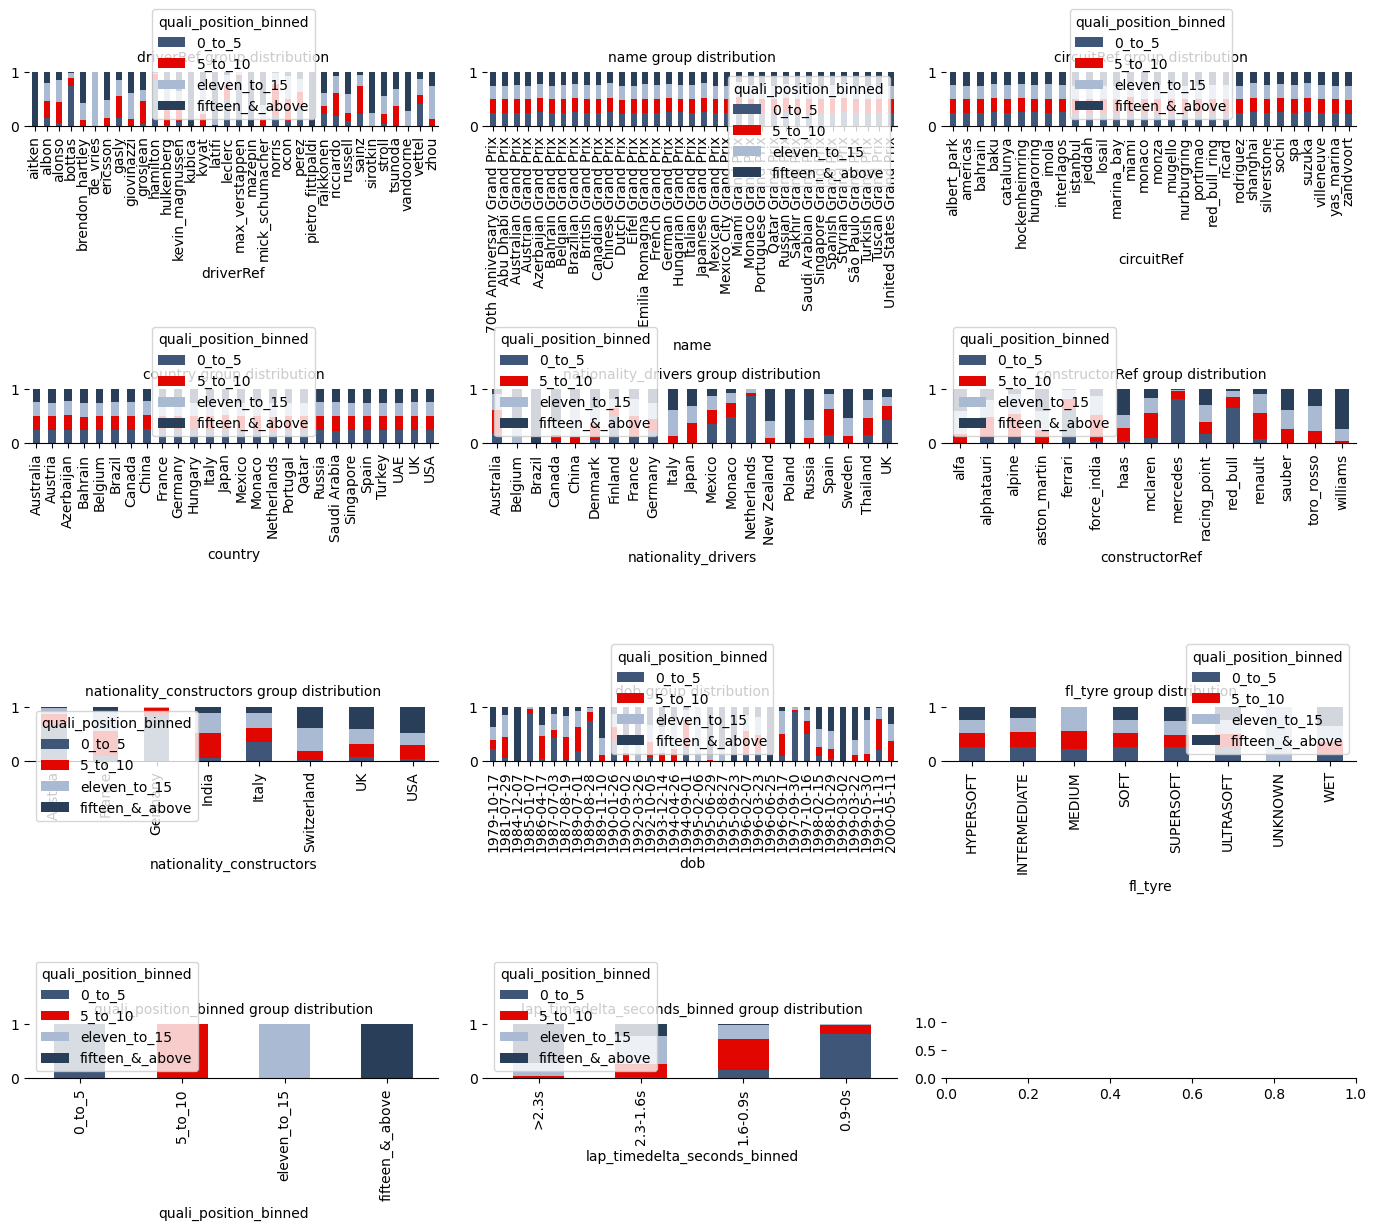

In [9]:

plot_categorical_cols_by_dim(display_df,'quali_position_binned',columns=3)

From the plots of categorical variables we can see the most variability with `driverRef` and `constructorRef`. Interestingly the tyres have a more uniform distribution with pole positions on every tyre, which was not expected. It was anctipated that the fastest laps would be baises to the soft compound tyres as these are supposed to be faster. However, the types of tyres are dedicated to the tyres by the manufacturer, and hence for different GrandPrix's the teams have different compounds of tyres to choose from and therefore the number of top position laps are reasonably well distributed across the tyre types.


Now to explore the numerical variables, There are over 80 numerical variables therefore these can not be done at a individual level. First we will plot the distribution of all the variables to see which are normally distributed and which are skewed.

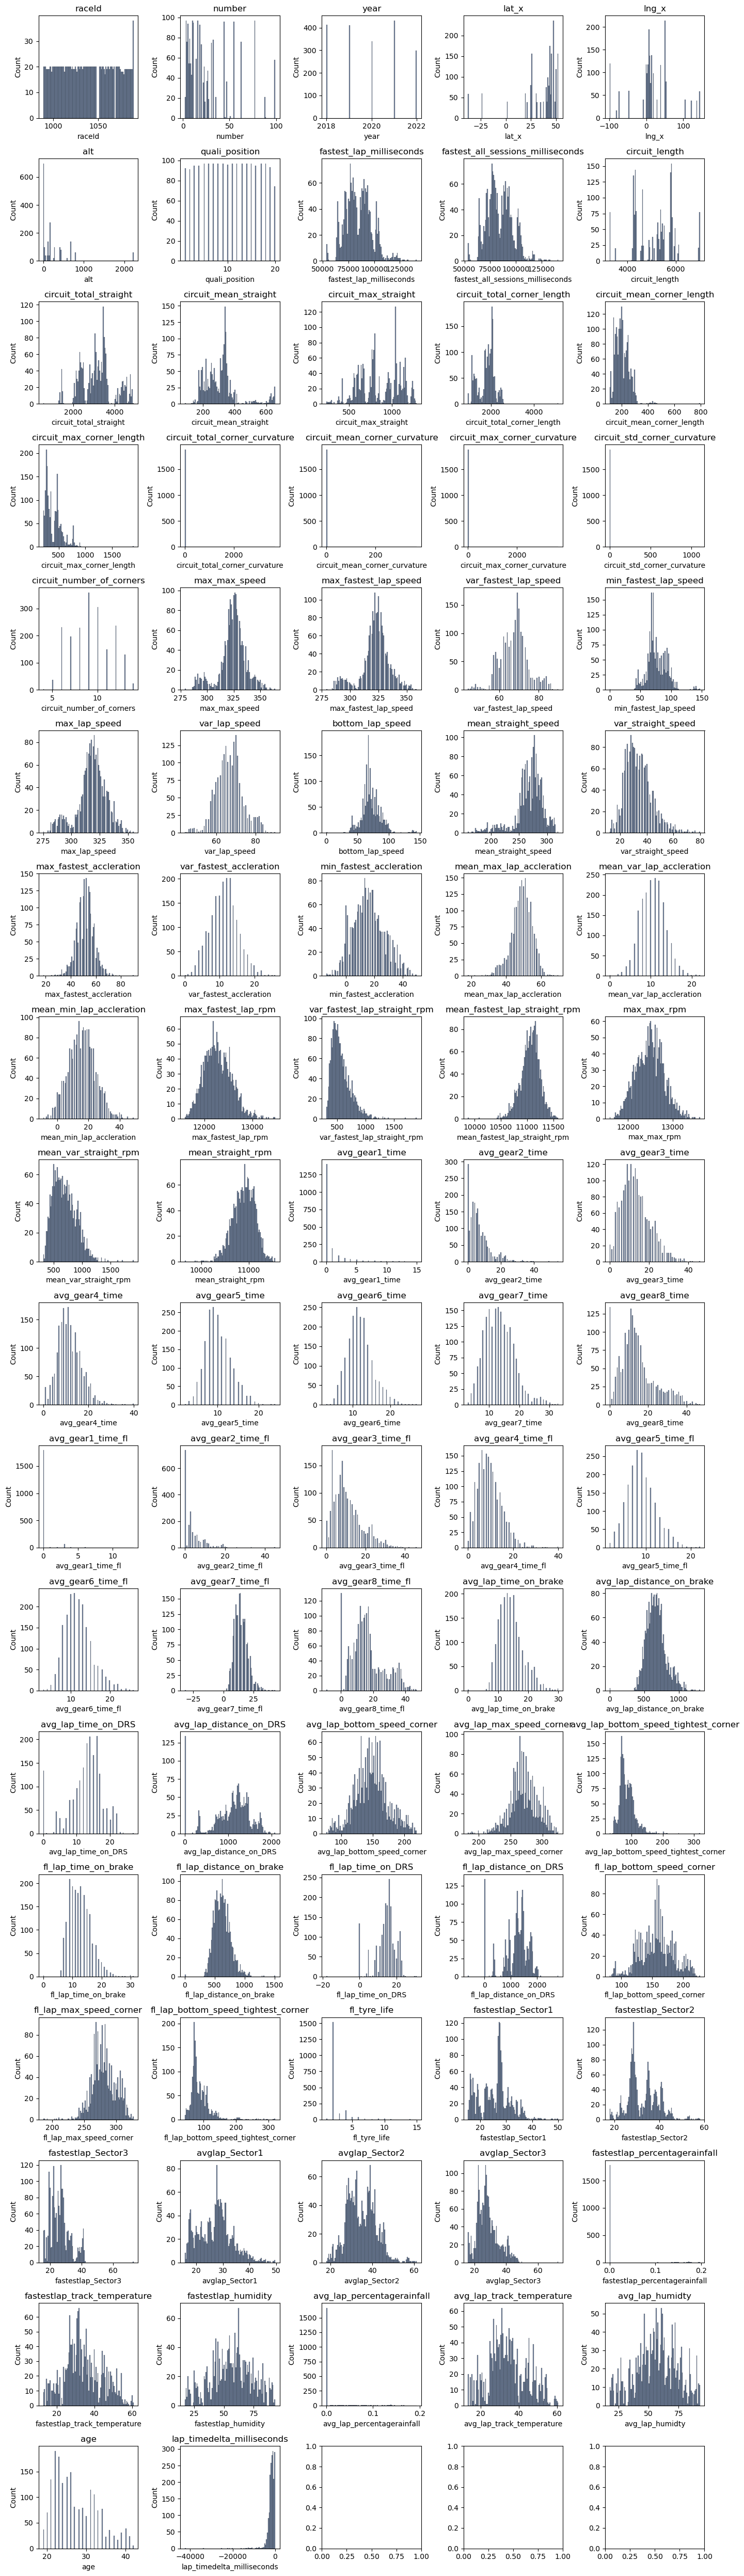

In [10]:
plot_numerical_variables_hist(display_df)

The majority of the variables are normally distributed with some key exceptions:
- Circuit curvature variables- this is most likely caused by some large outliers and maybe an anomaly in the calculation that could be investigated further with more time
- Variance in fastest lap RPM - Most engines/car have small variance with only few cars have a large variance in RPM
- Gear 1 and 2 time - most circuits do not spend time in Gear 1/2
- Tyre life - The fastest laps usually set on tyres with low number of laps allready completed
- Percentage Rainfall - most sessions in the dry

In addittion we can notice that DRS results have a spike at 0. This is caused by a error in the telemetry database and flag for DRS which is unknown.

We have this function which replaces the 0's with averages for the driver on that circuit from previous years:

In [6]:
display_df = fix_zero_DRS(display_df)

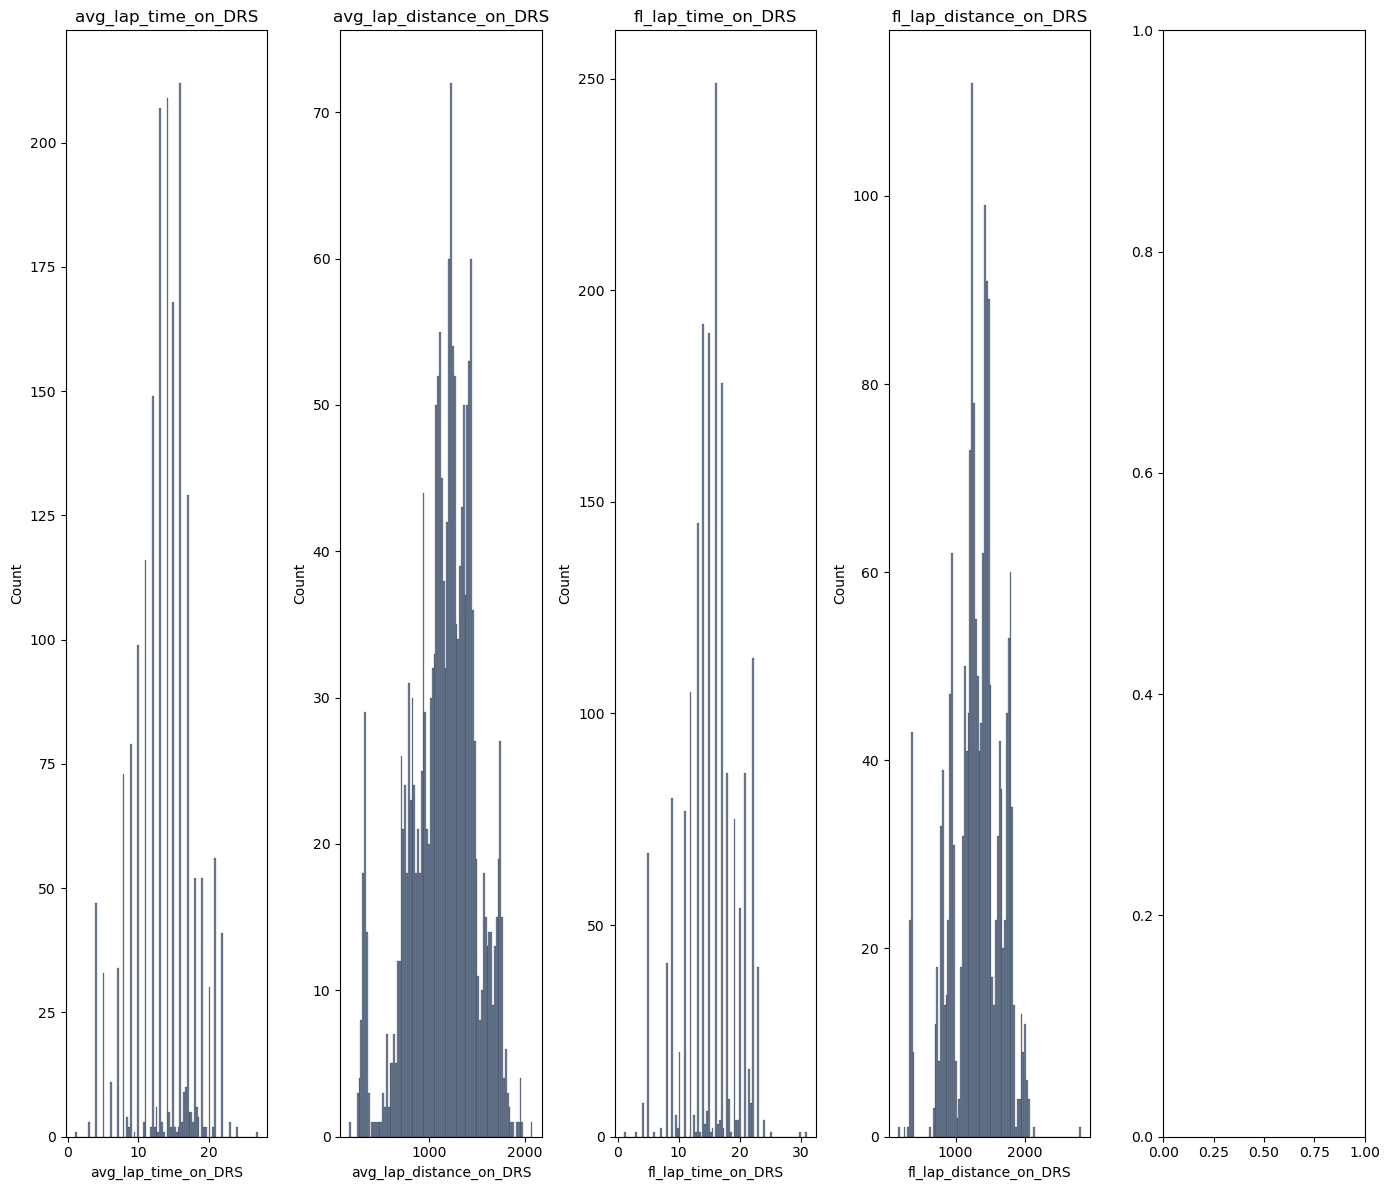

In [7]:
plot_numerical_variables_hist(display_df,columns=['avg_lap_time_on_DRS','avg_lap_distance_on_DRS','fl_lap_time_on_DRS','fl_lap_distance_on_DRS'])

We can see that the spike on 0 has no been removed and the features of DRS are normally distrubted

In [8]:
nan_checker(display_df)

This dataframe has 0 NaN values


## Prepare for modelling
<a id="prep"></a>
The raceids for test set where defined by a random selection of two races for each year. Another option will be to use a random train test split by Sklearn library, however this will select random driver results from lots of different grandprix's and this does not reflect reality as the model will learn something about every GrandPrix in every year. Whereas in reality, the model will recieve data for a whole GrandPrix in a year which it hasn't been trained on. Therefore it makes most sense to split the test by the results of whole GrandPrix's and not completely randomly. 

Therefore we will create a method to randomly select two races from each year:

In [11]:
# Random state fixed to ensure we get the same grandprix's each time
r = np.random.RandomState(13)
rand_races = r.randint(0,16,10)
years=[2018,2019,2020,2021,2022]
test_races=[]
b= 0
for i,year in enumerate(years):
    races = qualify_df_1.loc[qualify_df_1['year']==year,'raceId'].unique()    
    test_races.append(list(races[rand_races[b:b+2]]))    
    b=b+2
test_races =list(np.array(test_races).flatten())
test_races

[990, 989, 1026, 1010, 1041, 1036, 1061, 1073, 1088, 1084]

Which GrandPrix's are in our test set?

In [10]:
qualifying_df[qualifying_df['raceId'].isin(test_races)].groupby(['raceId','year','circuitRef']).count()['driverRef']

raceId  year  circuitRef   
989     2018  albert_park      20
990     2018  bahrain          20
1010    2019  albert_park      20
1026    2019  suzuka           18
1036    2020  catalunya        20
1041    2020  nurburgring      20
1061    2021  silverstone      20
1073    2021  yas_marina       20
1084    2022  red_bull_ring    19
1088    2022  zandvoort        19
Name: driverRef, dtype: int64

The data needs to be prepared before any predictions can be made. This is to ensure there are no NaN values (when driving data is not recorded), the columns are in the right format and the final target and feature engineering is complete. 
The prepare modelling function does all of this, it:
- converts columns which are numeric to float
- Creates the target features and bins
- Creates the home country feature
- Cleans the dataframe 
- Fixes the GrandPrix where the DRS telemetry data was not working. 

The raceId's are past into the function to do the test train split

In [15]:
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df, test_raceids=test_races)

In [16]:
print(f'percentage test data is {(len(X_test)/len(X_train))*100}')

percentage test data is 11.536197763390229


This is a small percentage of test data, which is normally 20%. However since there isn't much data and therefore limited data for the model to train on. It was decided to reduce the test set to 2 grandprix's for each year which is 11% of the train set.

## Column Transformer
<a id="col"></a>
As shown above there are categorical columns (drivers/teams) and large range of numerical variables. These will be passed into a column transformer which will hot encode the categorical columns and scale the numerical variables using a Standard Scaler. A standard scaler was used because of the range of distributions and not wanting to be affected by large outliers. Standard Scaler is slightly less affected by outliers so was chosen to scaler the data.

In [17]:
# Find the categorical columns and the numerical columns
hot_encode_col=list(X_train.select_dtypes("object").columns)
scale_cols = [col for col in X_train.columns if col not in hot_encode_col]

In [18]:
#Create a transformer using Sk Learn Column Transformer
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
col_transform = ColumnTransformer(transformers=transformer)  
col_transform

ColumnTransformer(transformers=[('numerical_transform', StandardScaler(),
                                 ['year', 'lat_x', 'lng_x', 'alt',
                                  'circuit_length', 'circuit_total_straight',
                                  'circuit_mean_straight',
                                  'circuit_max_straight',
                                  'circuit_total_corner_length',
                                  'circuit_mean_corner_length',
                                  'circuit_max_corner_length',
                                  'circuit_total_corner_curvature',
                                  'circuit_mean_corner_curvature',
                                  'circui...
                                  'min_fastest_lap_speed', 'max_lap_speed',
                                  'var_lap_speed', 'bottom_lap_speed',
                                  'mean_straight_speed', 'var_straight_speed',
                                  'max_fastest_accleration',
                                  'var_fastest_accleration',
                                  'min_fastest_accleration',
                                  'mean_max_lap_accleration',
                                  'mean_var_lap_accleration', ...]),
                                ('hot_encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['driverRef', 'circuitRef', 'constructorRef',
                                  'fl_tyre'])])

This dataframe demonstrates the column transformerand shows the numerical variables have been all scaled, to more reasonable numbers for modelling.

In [19]:
X_train_scaled_demonstration = pd.DataFrame(data=col_transform.fit_transform(X_train),columns=col_transform.get_feature_names_out())
X_train_scaled_demonstration.head()

,numerical_transform__year,numerical_transform__lat_x,numerical_transform__lng_x,numerical_transform__alt,numerical_transform__circuit_length,numerical_transform__circuit_total_straight,numerical_transform__circuit_mean_straight,numerical_transform__circuit_max_straight,numerical_transform__circuit_total_corner_length,numerical_transform__circuit_mean_corner_length,...,hot_encode__constructorRef_toro_rosso,hot_encode__constructorRef_williams,hot_encode__fl_tyre_HYPERSOFT,hot_encode__fl_tyre_INTERMEDIATE,hot_encode__fl_tyre_MEDIUM,hot_encode__fl_tyre_SOFT,hot_encode__fl_tyre_SUPERSOFT,hot_encode__fl_tyre_ULTRASOFT,hot_encode__fl_tyre_UNKNOWN,hot_encode__fl_tyre_WET
0,-1.351785,-0.679652,0.861438,-0.577038,0.441077,0.241018,-0.480703,0.961502,0.400372,-0.747795,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.351785,-0.679652,0.861438,-0.577038,0.442240,0.141700,-0.453081,0.880161,0.576758,-0.499067,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.351785,-0.679652,0.861438,-0.577038,0.444565,0.224061,-0.462288,0.807382,0.408270,-0.709529,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.351785,-0.679652,0.861438,-0.577038,0.437589,0.204682,-0.517533,0.978627,0.476718,-0.690396,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.351785,-0.679652,0.861438,-0.577038,0.441077,0.178036,-0.480703,0.867318,0.513575,-0.632997,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare the Target Variables
<a id="target"></a>
The Target variables are currently categorical columns of labels, `0-5` `5-10` etc for position and `0-0.8s` `0.8-1.5s` etc for Lap Time Delta. These categorical variables need to be converted to numerical variables that can be predicted, [0,1,2,3] etc for each target. This can be done with Sklearn LabelEncoder:

This has to be repeated for both the train and test set.

In [20]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
ydelta_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
ydelta_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])

In [21]:
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
ypos_train= labelencoder.transform(y_train['quali_position_binned'])
ypos_test= labelencoder.transform(y_test['quali_position_binned'])

## Find Important Features
<a id="featureimportance"></a>

Similar to the investigation undertaken in [5_Forumla1_Feature_Importance](./5_Forumla1_Feature_Importance.ipynb), finding the most important features will allow us to reduce the feature space. As disscused in the evaluation of the sample dataset we will look into two approaches, one using Manual Feature Selection and the other using Principal Component Analysis (PCA) to reduce the number of features to allow the models to perform better.

To be consistent we will at Qualifying Position target variable

### Random Forest Feature Importance
<a id="rf"></a>

First technique to measure Feature Importance is the Random Forest Feature importance. As Random Forest builds an ensemble of short trees it learns where each tree has a set number of features, it learns which features have the greatest impact and which do not. Therefore it is a good method to learn feature importance.

As shown above we need to transform the columns of our dataset, therefore to avoid issues we will use a pipeline of Column Transformer and Random Forest Classifer.

Then we can fit it to the model and extract the feature importances out

In [22]:
# Random Forest Pipeline
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [23]:
#fit the data
rf_model= forest_pipe.fit(X_train,ypos_train)

In [24]:
#Extract the feature importances
RF_results = pd.DataFrame(data=rf_model['random_forest'].feature_importances_ ,index=rf_model['column_transform'].get_feature_names_out())

In [25]:
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

In [26]:
#save results
RF_results.to_pickle('./data/model_data/feature_importance_random_forest.pkl')

### Select K best feature importance
<a id="sk"></a>

Select K best is the second technique, it looks at the stastical significance between the numerical variables and the target variable. The default we are using is a the ANOVA F-value between Target and Variable. 

In [27]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

select_k_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('select_k',SelectKBest())# classifier
        
]
select_pipe=Pipeline(select_k_estimator)

In [28]:
#fit the data
sel_model=select_pipe.fit(X_train,ypos_train)

In [29]:
#extract the results
select_results = pd.DataFrame(data=sel_model['select_k'].scores_ ,index=sel_model['column_transform'].get_feature_names_out())
select_results.rename(columns={0:'SelectKbest_result'},inplace=True)

### PCA feature importance
<a id="pca"></a>

Third technique is Principal Component Analysis. We will find the principal components which fit 90% of the data. Then inspect just the first two components and look at the explained variance to see which features the variance comes from

In [30]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

pca_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
      
        ('pca',PCA(n_components=0.9))# classifier
        
]
pca_pipe=Pipeline(pca_estimator)

In [31]:
pca_model=pca_pipe.fit(X_train,ypos_train)

Lets plot the explained varaince of the data by principal component. How many components can explain the data well?

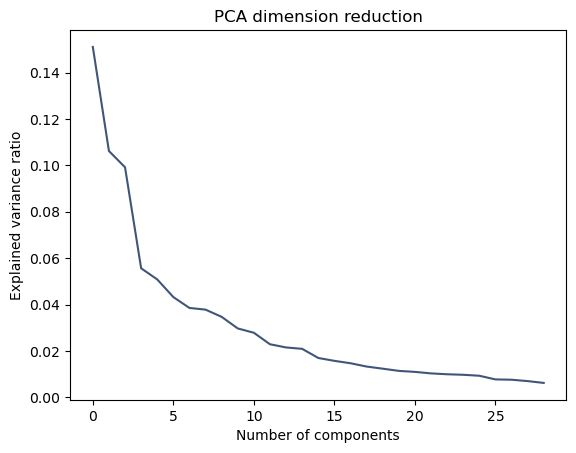

In [32]:
plt.figure()
plt.plot(np.arange(0,pca_model['pca'].n_components_,1),pca_model['pca'].explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of components')
plt.title('PCA dimension reduction')
plt.show()

The explained variance rapidly drops with the first 3/4 components showing that these components are the most valuable and capture majority of the variance of the data. After PCA 10 the amount of variance the components contribute to drops off significantly.

How many components explain 90% of the variance?

In [33]:
len(pca_model['pca'].explained_variance_)

29

29 components explain 90% of the variance.

What makes up each of the components? We can extract the explained variance ratio for the first 2 components to compare to Random Forest and Select K Best:

In [34]:
pca_results = pd.DataFrame(data=pca_model['pca'].components_[0:2],columns=pca_model['column_transform'].get_feature_names_out(),index=['PCA1','PCA2'])

### Comparison of Feature Importane Results
<a id="compare"></a>
To Compare the feature importance we will combine the results and scaler the numerical values so they cover the same range for each technique:

In [35]:
all_results = pd.concat([RF_results,select_results,pca_results.T.abs()],axis=1)
scaler=StandardScaler()
all_results_scaled = scaler.fit_transform(all_results)
all_results_2 = pd.DataFrame(data=all_results_scaled,index=all_results.index,columns=all_results.columns)

In [36]:
all_results_2.to_pickle('./data/model_data/feature_importance_results.pkl')

Plot the results for each technique:

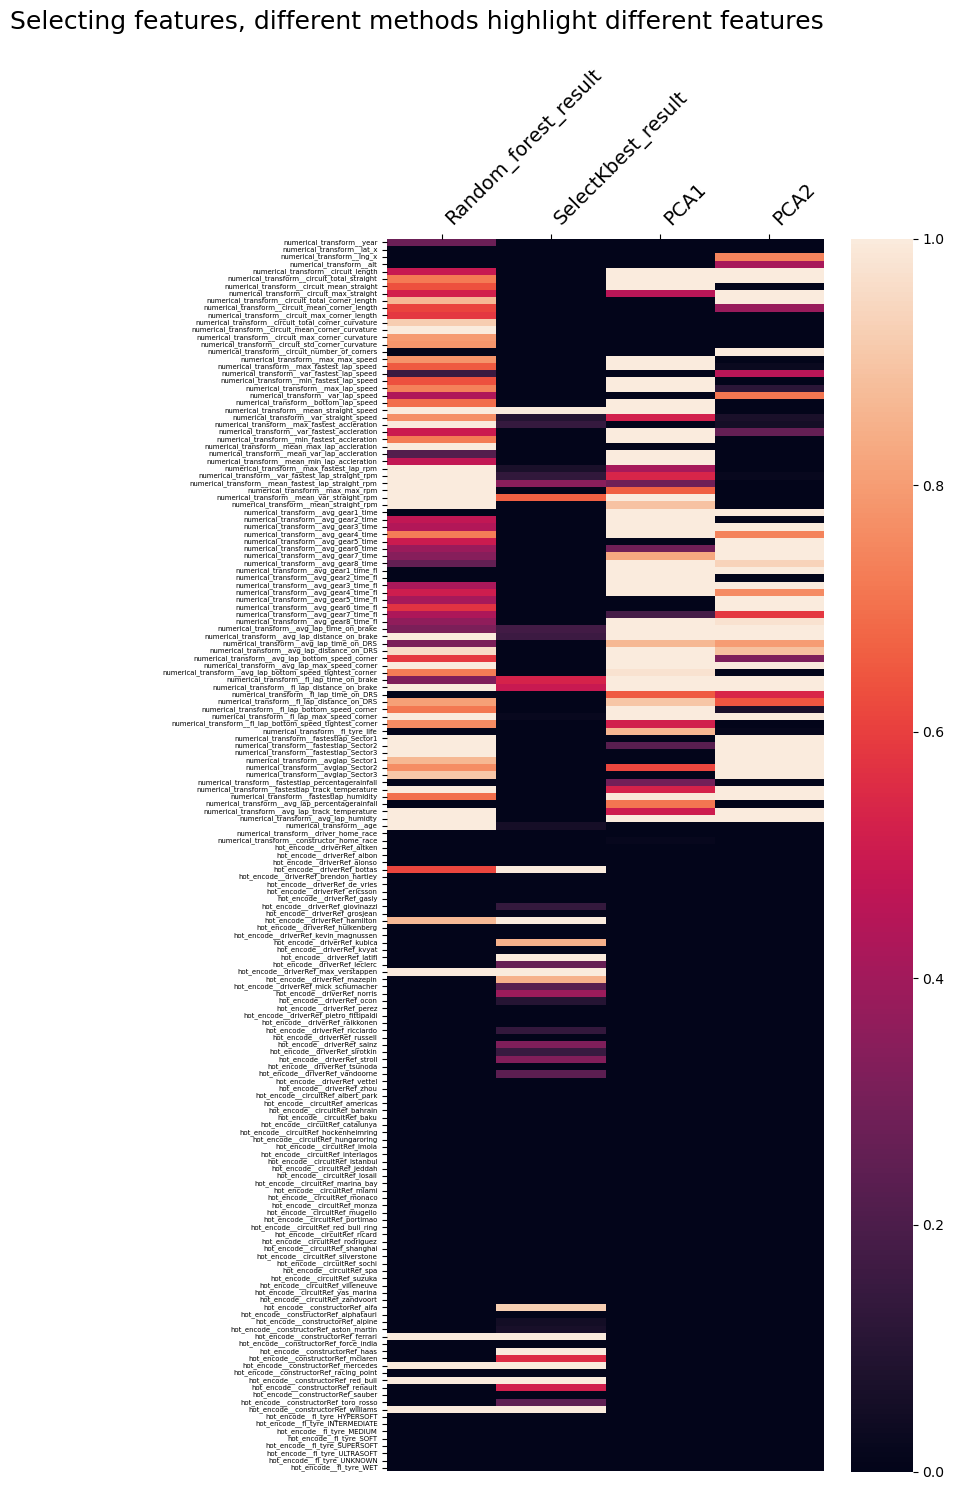

In [37]:
plt.figure(figsize=(8,15))
sns.heatmap(all_results_2, vmax=1, vmin=0)

plt.gca().xaxis.tick_top()
plt.title('Selecting features, different methods highlight different features\n',loc='right',fontsize=18)
plt.xticks(rotation = 45,ha='left',fontsize=14)
plt.yticks(np.arange(0.5,(len(all_results_2.index)+0.5)),labels=all_results_2.index,va="center",fontsize=5)
#plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('./images/feature_selection_all_data_full_v2.jpg',dpi=300,bbox_inches='tight')
plt.show()

The results for the fully dataset are very similar to those from the sample shown in [5_Forumla1_Feature_Importance](./5_Forumla1_Feature_Importance.ipynb). 

Random Forest has selected some of the top drivers:
- Hamilton 
- Verstappen
and teams:
- Ferrari
- Mercedes
- Red Bull

In addition it selects interesting features such as:
- Time and distance on Brakes
- All the features on RPM
- Speed
- Corner curvature

different to the sample it didn't rate the time in individual gear that highly. 

Select K Best selected majoirt of the top teams and drivers, plus a couple of variables such as:
- Mean Straight Speed
- RPM
- Distance on brake

PCA components 1 and 2 was different to Random Forest and Select K Best.

These components took a lot fo the variance from the numerical engineer features, and they are the opposite of each other. PCA 1 takes variance from the Braking features, whereas PCA2 takes variance from the sector times.

It is also worth noting that the Feature Fastest Lap Sector 1, 2 and 3 times are the break down of the lap times for the fastest lap and hence are so closely related to the target variable of lap time, and hence should not be included in modelling.

What is the intitial score of the Random Forest Model that we fitted to look at feature importance.

In [38]:
print(f'Vanilla starting Random Forest Score is {rf_model.score(X_test,ypos_test)}')

Vanilla starting Random Forest Score is 0.5357142857142857


A good start, something we will look into more later.

## Baseline Logisitic Regression Model
<a id="logreg"></a>

Now we have established the important features, let start with an intial baseline model to predict the classifications of Qualifying Position and Lap time delta.

In this we will compare the results for Manually selecting the features, automatically selecting the features and using PCA.

### Manually Selected Features


First model we will build will investigate building a model by manually selecting the important features. Which are the important features?

To find the important features, we will use the Random Forest Feature Importance because this seemed to capture a good spread of important features from Teams, drivers to numerical telemetry features.

First lets plot the Random Forest Feature importance as a bar graph:

<Figure size 640x480 with 0 Axes>

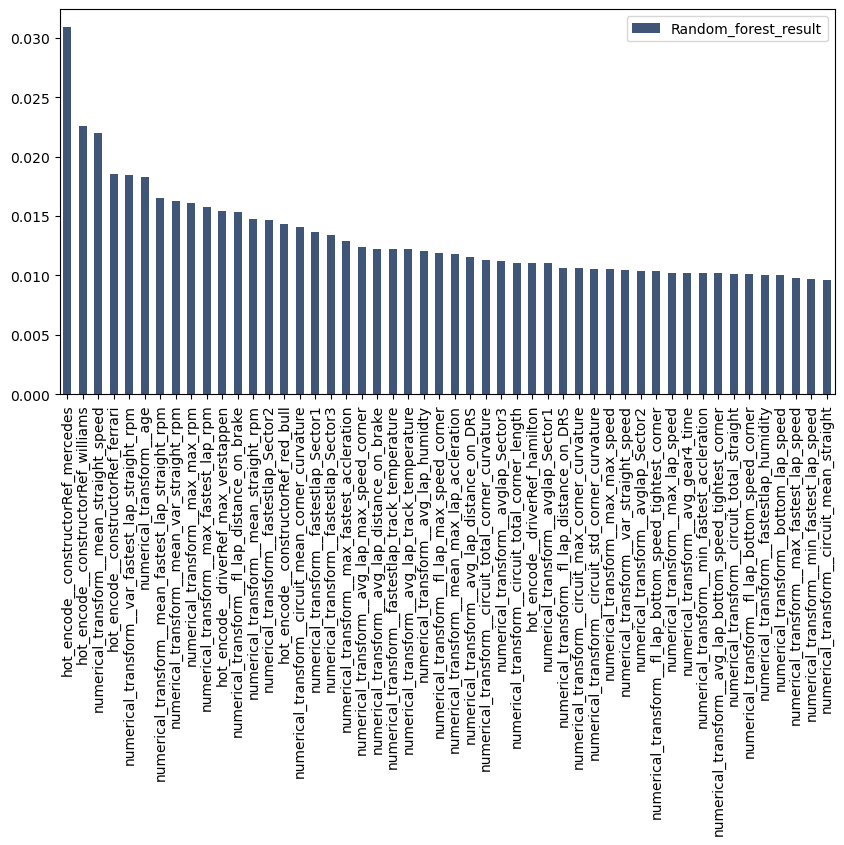

In [39]:
plt.figure()
RF_results.sort_values(by='Random_forest_result',ascending=False).head(50).plot(kind='bar',figsize=(10,5))
plt.show()

We can see that Mercedes is the most important feature and then the feature importance drops of the next 15 or so variables before tailing off around 0.01. A value around 0.01 would capture the top important features and seem to reduce the feature space considerably. 

We can also use a threshold which is scaler on the mean result of feature importance. Mean result * 1.75 gives us a value close to 0.01. We can plot that below.

In [40]:
RF_results[RF_results['Random_forest_result'] > RF_results['Random_forest_result'].mean()*1.75].sort_values(by='Random_forest_result',ascending=False)

,Random_forest_result
hot_encode__constructorRef_mercedes,0.030886
hot_encode__constructorRef_williams,0.022552
numerical_transform__mean_straight_speed,0.021988
hot_encode__constructorRef_ferrari,0.018576
numerical_transform__var_fastest_lap_straight_rpm,0.018431
numerical_transform__age,0.018278
numerical_transform__mean_fastest_lap_straight_rpm,0.016525
numerical_transform__mean_var_straight_rpm,0.016262
numerical_transform__max_max_rpm,0.016096
numerical_transform__max_fastest_lap_rpm,0.015784


This looks like a good selection of features, as we have selected a good list of the telemetry features as well as some of the important categorical variables.

Lets generate a list of these to be able to manualy cut down the features:

In [41]:
manual_features = list(RF_results[RF_results['Random_forest_result']>0.0105].index)

As discussed the Fastest Lap Sector times are a break down of the Fastest Lap time which is our feature to predict. Therefore we will remove these:

In [42]:
features_remove =[ 'numerical_transform__fastestlap_Sector1',
 'numerical_transform__fastestlap_Sector2',
 'numerical_transform__fastestlap_Sector3', 
 ]

In [43]:
manual_features = [x for x in manual_features if x not in features_remove]

In [44]:
len(manual_features)

33

This has give us an inital list of 30 features. However since we pass our Categorical and Numerical features through a column transformer first it is therefore difficult for us to select the dummy variables before they are transformed. Therefore we can only actually select the numerical columns that were selected, and select the driver and car categorical columns and lose the rest. This will increase the number of features as we include more dummy features than was shown to be significant. However if we use models such as Random Forest, those un important dummy variables will get weeded out. 


## Dimension Reduction Analysis with Logisitic Regression Prediction 
<a id="manual"></a>
We will compare 3 different feature selection techniques with a logistic regression prediction.
1) Manual selection, of important telemetry features, drivers and teams
2) Automatic selection
3) PCA dimension reduction

The function below reduces the features of X using the manual selection

The second function provides the new column names for the transform

In [75]:
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [76]:
#Logisitc Regression Pipeline
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('log_reg',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

#### Logisitic Regression Qualifying Position Prediction with Manual Features

Position Logisitic Initial train score with manual selected features 0.6174220129487934
Position Logisitic Initial test score with manual selected feaures 0.5918367346938775


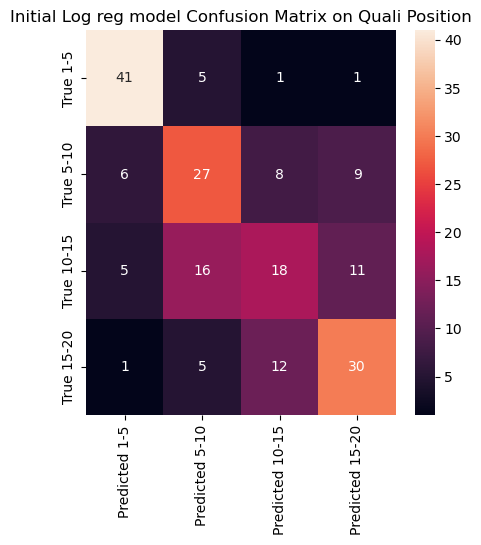

In [77]:
log_model_pos= log_pipe.fit(X_train_manual,ypos_train)
print(f'Position Logisitic Initial train score with manual selected features {log_model_pos.score(X_train_manual,ypos_train)}')
print(f'Position Logisitic Initial test score with manual selected feaures {log_model_pos.score(X_test_manual,ypos_test)}')
y_pred=log_model_pos.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 1-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 1-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Initial Log reg model Confusion Matrix on Quali Position')
plt.show()

The intial logsitic classifer does reasonably well straight with default parameters, with a test score of 0.6. The confusion matrix shows it does reasoably well at predicting the top drivers, however it gets more confused towards the rear of the pack. With it miss clasifying 20 drivers as in the last category which were in fact in the middle of the pack. We can see that does well not classify bottom drivers as top but miss classifys drivers into the neighbouring bin.

This maybe done to the way the data was binned, which we will come onto later.

#### Logisitic Regression Qualifying Lap Time Delta Prediction with manual features

Delta Logisitic Initial train score with manual selected features 0.618599175985874
Delta Logisitic Initial test score with manual selected feaures 0.6071428571428571


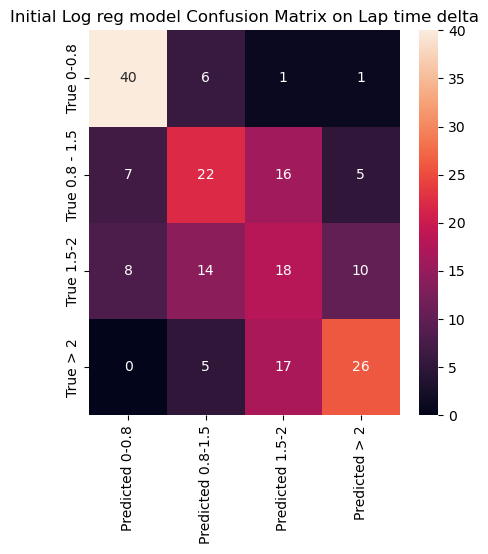

In [78]:
log_model_delta= log_pipe.fit(X_train_manual,ydelta_train)
print(f'Delta Logisitic Initial train score with manual selected features {log_model_delta.score(X_train_manual,ydelta_train)}')
print(f'Delta Logisitic Initial test score with manual selected feaures {log_model_delta.score(X_test_manual,ydelta_test)}')
y_pred=log_model_delta.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Initial Log reg model Confusion Matrix on Lap time delta')
plt.show()

For lap time delta, similarly the vanilla logistic regression on manual features has a good starting score of 0.6. It also does ok, not predicting a bottom driver as a fast driver and visa versa. However it does also miss classify dirvers into the neighbouring class. Which maybe done to the bin size.

## PCA dimension reduction
<a id="pca2"></a>
Second technique for dimension reduction will use PCA components

Using the vanilla logisitic regression to compare with manual selection.

In [120]:
scale_cols, hot_encode_col = column_lists(X_train)

In [121]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

Log_reg_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('pca', PCA()),
        ('log_reg',LogisticRegression())# classifier
        
]
log_reg_pipe=Pipeline(Log_reg_estimator)

In [122]:
log_reg_pipe.set_params(pca__n_components=0.9) # use all 29 components (90% of the variance)
log_model_pos = log_reg_pipe.fit(X_train,ypos_train)
print(f'Position Log Reg Initial train score with PCA selected features {log_model_pos.score(X_train,ypos_train)}')
print(f'Position Initial test score with PCA selected feaure {log_model_pos.score(X_test,ypos_test)}')
log_model_delta= log_reg_pipe.fit(X_train,ydelta_train)
print(f'Lap Delta Log Reg Initial train score with PCA selected features {log_model_delta.score(X_train,ydelta_train)}')
print(f'Lap Delta Log Reg Initial test score with PCA selected feaure {log_model_delta.score(X_test,ydelta_test)}')

Position Log Reg Initial train score with PCA selected features 0.41024131842260153
Position Initial test score with PCA selected feaure 0.34183673469387754
Lap Delta Log Reg Initial train score with PCA selected features 0.468510888758093
Lap Delta Log Reg Initial test score with PCA selected feaure 0.3826530612244898


The accuracy scores of the model using PCA as dimension reduction is sighnificantly worse than manual feature selection. Accuracy scores of 0.3 on the test data.

How does the confusion matrix look?

#### Logisitic Regression Qualifying Position Prediction with PCA

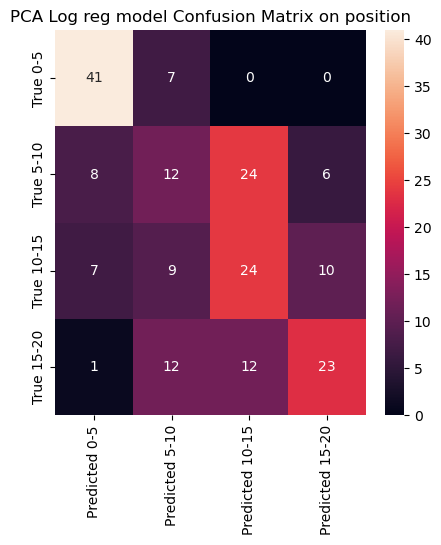

In [123]:
ypred= log_model_pos.predict(X_test)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('PCA Log reg model Confusion Matrix on position')
plt.show()

On face value the confusion matrix is ok, it stil is not predicting top drivers as last, however it has more miss classifications into neighbouring bins than the manual feature selection model. The confusion matrix looks much worse than with manual feature selection.

#### Logisitic Regression Qualifying Lap Time Delta Prediction with PCA

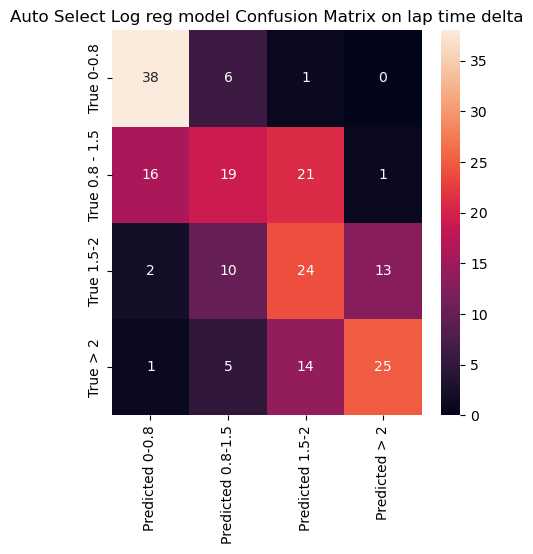

In [124]:
ypred= log_model_delta.predict(X_test)
log_confusion_matrix = confusion_matrix(ydelta_test,y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Auto Select Log reg model Confusion Matrix on lap time delta')
plt.show()

Similar the PCA model on lap time delta, seems good at face value with more of the middle drivers correctly assigned along the diagonal. However there are more miss clasifications for the top drivers and hence it gets a worse score.

## Features Selected with Select from Model
<a id="auto"></a>
The third technique is very similar to manual feature selection, except that the features will be automatically selected rather than manually applying a threshold. This could work better for automation in the future.

In [112]:
#get the column lists to pass into the transformer for the whole dataset
scale_cols, hot_encode_col = column_lists(X_train)

In [113]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('select_from_model',SelectFromModel(RandomForestClassifier(),threshold='1.75*mean')), # use a threshold of 1.75* the mean, the same as was used to do manual feature selection.
        ('log_reg',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

#### Logisitic Regression Qualifying Position Prediction with Automatic feature selection

In [114]:
log_model_pos = log_pipe.fit(X_train,ypos_train)
y_pred=log_model_pos.predict(X_test)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)

Position Logisitic Initial train score with auto selected features 0.5473808122424956
Position Logisitic Initial test score with auto selected feaures 0.576530612244898


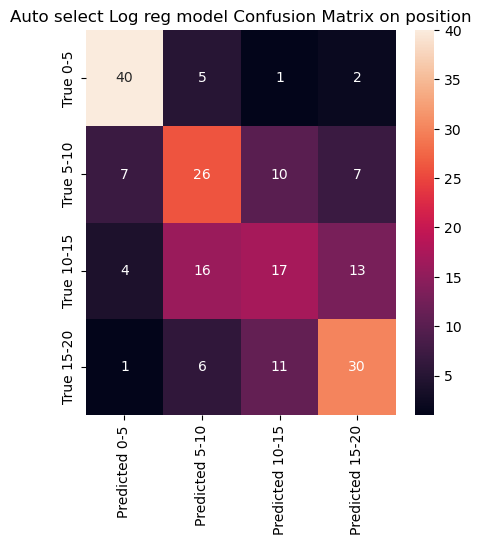

In [115]:
print(f'Position Logisitic Initial train score with auto selected features {log_model_pos.score(X_train,ypos_train)}')
print(f'Position Logisitic Initial test score with auto selected feaures {log_model_pos.score(X_test,ypos_test)}')

plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Auto select Log reg model Confusion Matrix on position')
plt.show()

We can see from the scores of Qualifying Position Prediction that it has a very similar output to the manual features. This is because the threshold has been set so it has very similar features. A number of iterations were conducted as it was found that no other value for threshold could beat manual feature selection.

This is because it takes all the same good numerical telemetry columns and all the categorical columns of driver and teams. Whereas select from model will get the same selection of telemetry features but not all the drivers and teams.

#### Logisitic Regression Qualifying Lap time delta Prediction with automatic feature selection

In [118]:
log_model_delta= log_pipe.fit(X_train,ydelta_train)
y_pred=log_model_delta.predict(X_test)
log_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

Position Logisitic Initial train score with auto selected features 0.5232489699823426
Position Logisitic Initial test score with auto selected feaures 0.5459183673469388


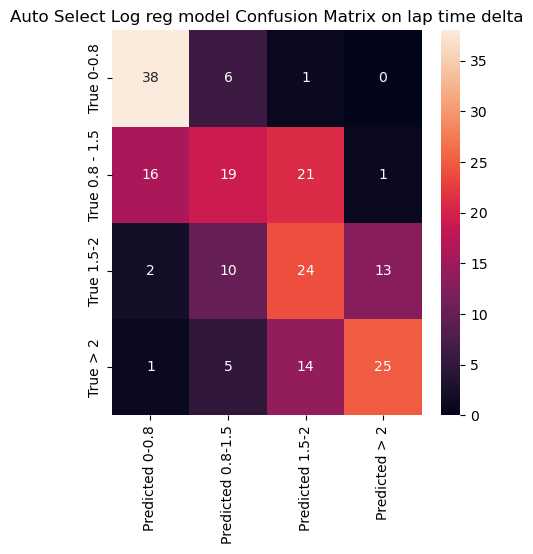

In [119]:
print(f'Position Logisitic Initial train score with auto selected features {log_model_pos.score(X_train,ydelta_train)}')
print(f'Position Logisitic Initial test score with auto selected feaures {log_model_pos.score(X_test,ydelta_test)}')
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Auto Select Log reg model Confusion Matrix on lap time delta')
plt.show()

For lap time delta, automatic feature selection actually performers worse than manual selection on accuracy. The confusion matrix looks similar, however there are more miss classifications for the fast drivers than in manaual feautre selection. 

# Summary of dimension reduction techniques
<a id="summary"></a>
In summary we can see that manual feature selection performed the best on the with the vanilla logisitic regression model. 

|    | Dimension Reduction Technique      | Target   |  Accuracy|     
|---:|:-----------------------------------|:---------|---------:|
|  0 | Manual Feature Selection           | Position | 0.59     |    
|  1 | Manual Feature Selection           | LapDelta | 0.61     | 
|  2 | PCA                                | Position | 0.34     |     
|  3 | PCA                                | LapDelta | 0.38     | 
|  4 | Automatic Feature Selection        | Position | 0.57     |     
|  5 | Automatic Feature Selection        | LapDelta | 0.54     | 

The PCA dimension reduction performed worse with the most miss clasification. It performed especailly poorly on Qualifying position. This may be because it is missing the variance for the top driver and teams dummy encoded variables and hence losing important features. This features may be espeically important for Qualifying position because often one team or a few teams are dominant at any one time and hence are often at the front. 

Automatic feature selection can not improve on manual feature selection, in addittion in this test it uses the Fastest Sector time which is a break down of the target. Hence if automatic feature selection was to be taken forward these features would need to be removed. However, since it does not perform any better than manual feature selection. Going forward the next model iteration will soley focus on manual feature selection

# Next Steps
<a id="nextsteps"></a>
The next steps are to explore other modelling techniques using the manual features selected in this analysis to see if we can find a modelling technique that can improve the accuracy of the model. The next notebook will evaluate Random Forest technique in predicting the classification of `Qualifying Position` and `Lap Time Delta`

The confusion matrix's showed us that the model has difficulty classifying points in neighbouring bins in the middle of the pack. This may be down to how the bins were generated, since the data was original continuous and binned, drivers may be close to the edges of the bin and hence the model can easily assign it into a neighbouring bin. 

This analysis focused on classification as it expected regression techniques to be too challenging for the models, since position is a ranked score and lap time delta is likely to be a hard variable to predict. However the early basic logisitc regression confusion matrix's show that the models are getting the predictions mostly right, and the miss classification is around the neighbouring bins. This maybe due to the bin size being too large. Hence we wil look into regression modelling in the following notebooks as well.



# Appendix
<a id="appendix"></a>
Experimentation on optimising Logisitc Regression for Manual Features and running basic Decision Trees was conducted, the results can be found here:

## Optimise Logistic Regression

## Manual Selection of Features

### Qualifying position

In [62]:
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [63]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

logisitic_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('log_reg',LogisticRegression())# classifier
        
]
log_pipe=Pipeline(logisitic_estimator)

In [64]:
log_grid=[
    {
        'log_reg__solver': ['lbfgs'],
        'log_reg__penalty':['l2'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {
        'log_reg__solver': ['liblinear'],
        'log_reg__penalty':['l1'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
]

grid_log=GridSearchCV(log_pipe,log_grid,cv=5,verbose=1,return_train_score=True,n_jobs=-1)
fittedgrid_log=grid_log.fit(X_train_manual,ypos_train)

print(fittedgrid_log.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'log_reg__C': 10000, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}


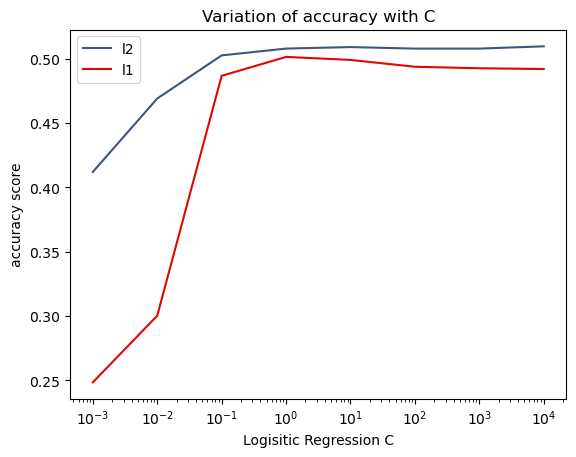

In [65]:
plt.figure()
sns.lineplot(data = fittedgrid_log.cv_results_ ,x ='param_log_reg__C', y='mean_test_score', hue='param_log_reg__penalty')
#plt.scatter(fittedgrid_log.cv_results_['param_log_reg__C'].data, fittedgrid_log.cv_results_['mean_train_score'],label='Train score')
plt.title('Variation of accuracy with C')
plt.ylabel('accuracy score')
plt.xlabel('Logisitic Regression C')
plt.xscale('log')
plt.legend()
plt.show()

In [66]:
print('Best Logisitic Regression quali position model accuracy_score on X test:',fittedgrid_log.best_estimator_.score(X_test_manual, ypos_test))

Best Logisitic Regression quali position model accuracy_score on X test: 0.5663265306122449


In [67]:
y_pred=fittedgrid_log.best_estimator_.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ypos_test,y_pred)

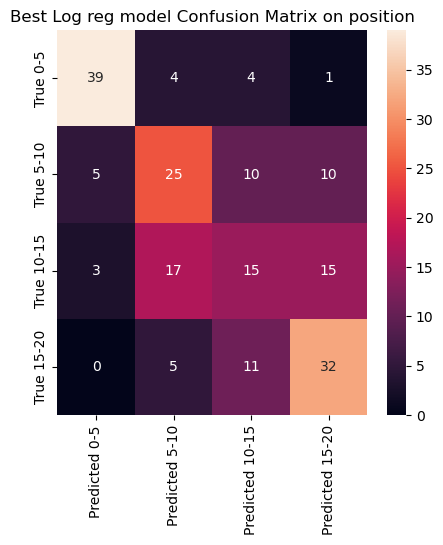

In [68]:
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Best Log reg model Confusion Matrix on position')
plt.show()

## Lap time delta

In [69]:
log_grid=[
    {
        'log_reg__solver': ['lbfgs'],
        'log_reg__penalty':['l2'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    {
        'log_reg__solver': ['liblinear'],
        'log_reg__penalty':['l1'],
        'log_reg__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
]

grid_log=GridSearchCV(log_pipe,log_grid,cv=5,verbose=1,return_train_score=True,n_jobs=-1)
fittedgrid_log=grid_log.fit(X_train_manual,ydelta_train)

print(fittedgrid_log.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'log_reg__C': 1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}


In [70]:
print(fittedgrid_log.best_params_)

{'log_reg__C': 1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}


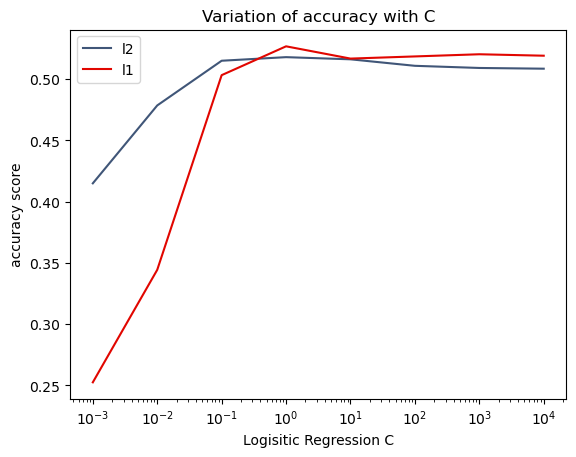

In [71]:
plt.figure()
sns.lineplot(data = fittedgrid_log.cv_results_ ,x ='param_log_reg__C', y='mean_test_score', hue='param_log_reg__penalty')
#plt.scatter(fittedgrid_log.cv_results_['param_log_reg__C'].data, fittedgrid_log.cv_results_['mean_train_score'],label='Train score')
plt.title('Variation of accuracy with C')
plt.ylabel('accuracy score')
plt.xlabel('Logisitic Regression C')
plt.xscale('log')
plt.legend()
plt.show()

In [72]:
print('Best Logisitic Regression lap delta model accuracy_score on X test:',fittedgrid_log.best_estimator_.score(X_test_manual, ydelta_test))

Best Logisitic Regression lap delta model accuracy_score on X test: 0.6122448979591837


In [73]:
y_pred=fittedgrid_log.best_estimator_.predict(X_test_manual)
log_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

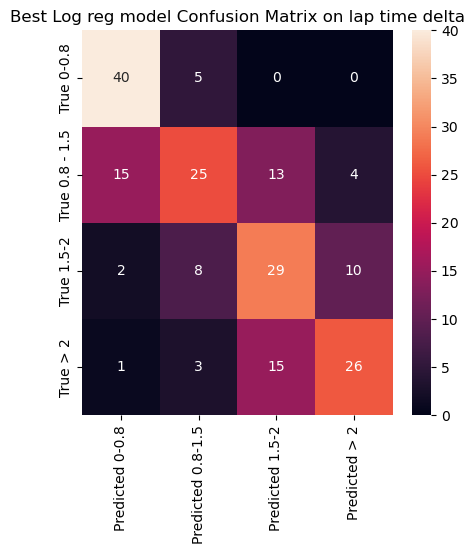

In [74]:
plt.figure(figsize=(5,5))
sns.heatmap(log_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best Log reg model Confusion Matrix on lap time delta')
plt.show()

## Decision Tree

In [53]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

dt_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        
        ('decision_tree',DecisionTreeClassifier(max_depth=5))# classifier
        
]
dt_pipe=Pipeline(dt_estimator)

In [54]:
dt_model_pos= dt_pipe.fit(X_train_manual,ypos_train)
print(f'Position DT Initial train score with manual selected featuers  {dt_model_pos.score(X_train_manual,ypos_train)}')
print(f'Position DT Initial test score with manual selected feaure  {dt_model_pos.score(X_test_manual,ypos_test)}')
dt_model_delta= dt_pipe.fit(X_train_manual,ydelta_train)
print(f'Lap Delta DT Initial train score with manual selected featuers  {dt_model_delta.score(X_train_manual,ydelta_train)}')
print(f'Lap Delta DT Initial test score with manual selected feaure {dt_model_delta.score(X_test_manual,ydelta_test)}')

Position DT Initial train score with manual selected featuers  0.5173631547969394
Position DT Initial test score with manual selected feaure  0.49489795918367346
Lap Delta DT Initial train score with manual selected featuers  0.5520894643908181
Lap Delta DT Initial test score with manual selected feaure 0.4744897959183674


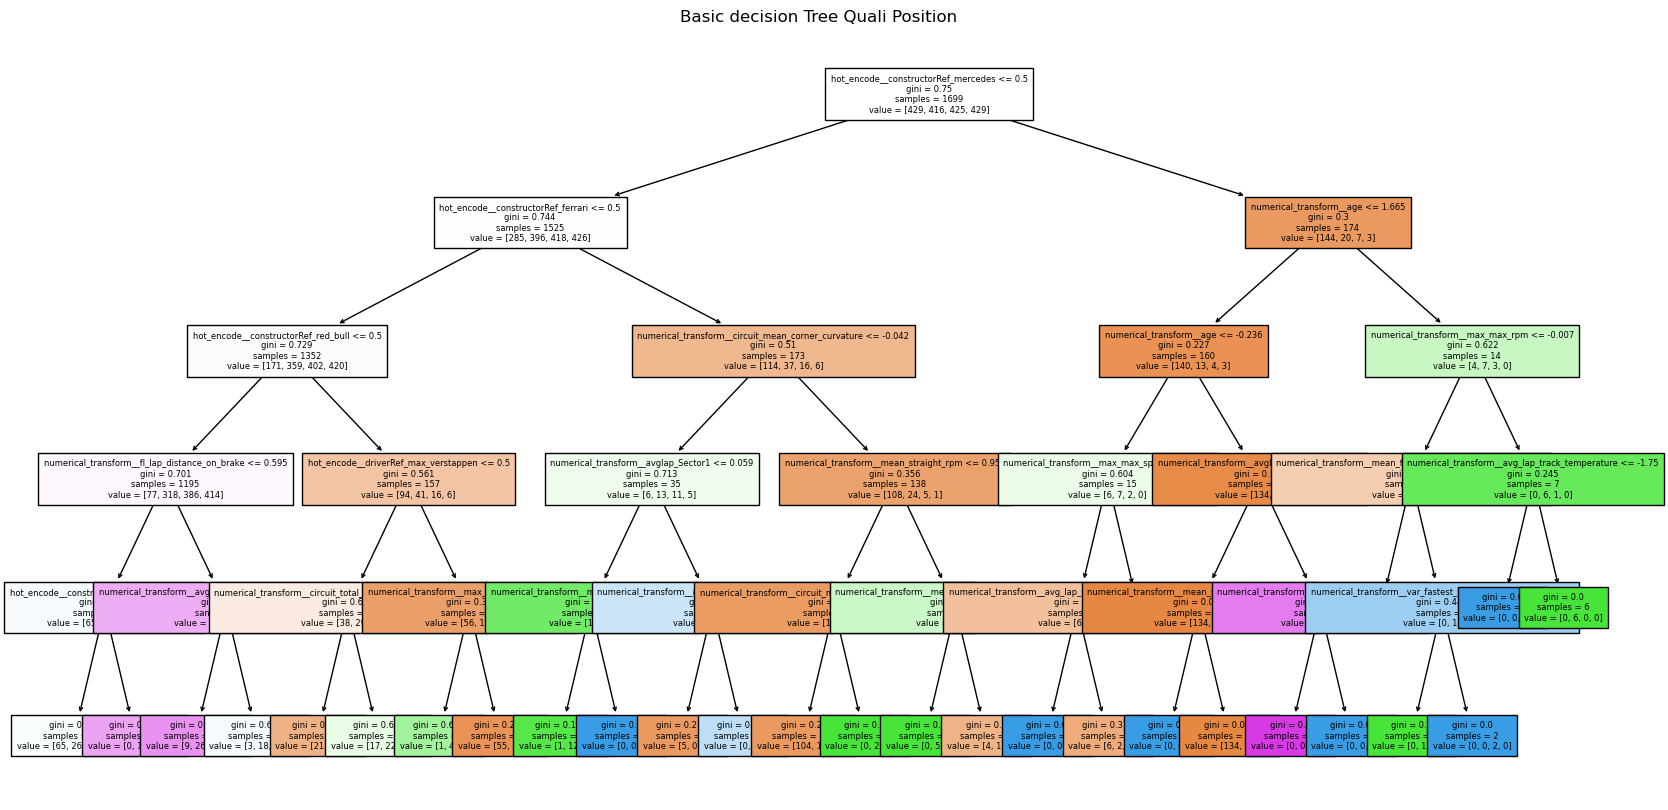

In [55]:
plt.figure(figsize=(20,10))

plot_tree(dt_model_pos.named_steps['decision_tree'],feature_names=dt_model_pos[:-1].get_feature_names_out(),filled=True, fontsize=6)
plt.title('Basic decision Tree Quali Position')
plt.show()

## Decision Tree

In [59]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

dt_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),
        ('pca', PCA()),
        ('decision_tree',DecisionTreeClassifier(max_depth=5))# classifier
        
]
dt_pipe=Pipeline(dt_estimator)

In [60]:
dt_pipe.set_params(pca__n_components=15)
dt_model_pos= dt_pipe.fit(X_train,ypos_train)
print(f'Position DT Initial train score with PCA selected features  {dt_model_pos.score(X_train,ypos_train)}')
print(f'Position DT Initial test score with PCA selected feaures  {dt_model_pos.score(X_test,ypos_test)}')
dt_model_delta= dt_pipe.fit(X_train,ydelta_train)
print(f'Lap Delta DT Initial train score with PCA selected featuers  {dt_model_delta.score(X_train,ydelta_train)}')
print(f'Lap Delta DT Initial test score with PCA selected feaures {dt_model_delta.score(X_test,ydelta_test)}')

Position DT Initial train score with PCA selected features  0.3890523837551501
Position DT Initial test score with PCA selected feaures  0.2857142857142857
Lap Delta DT Initial train score with PCA selected featuers  0.4502648616833431
Lap Delta DT Initial test score with PCA selected feaures 0.28061224489795916


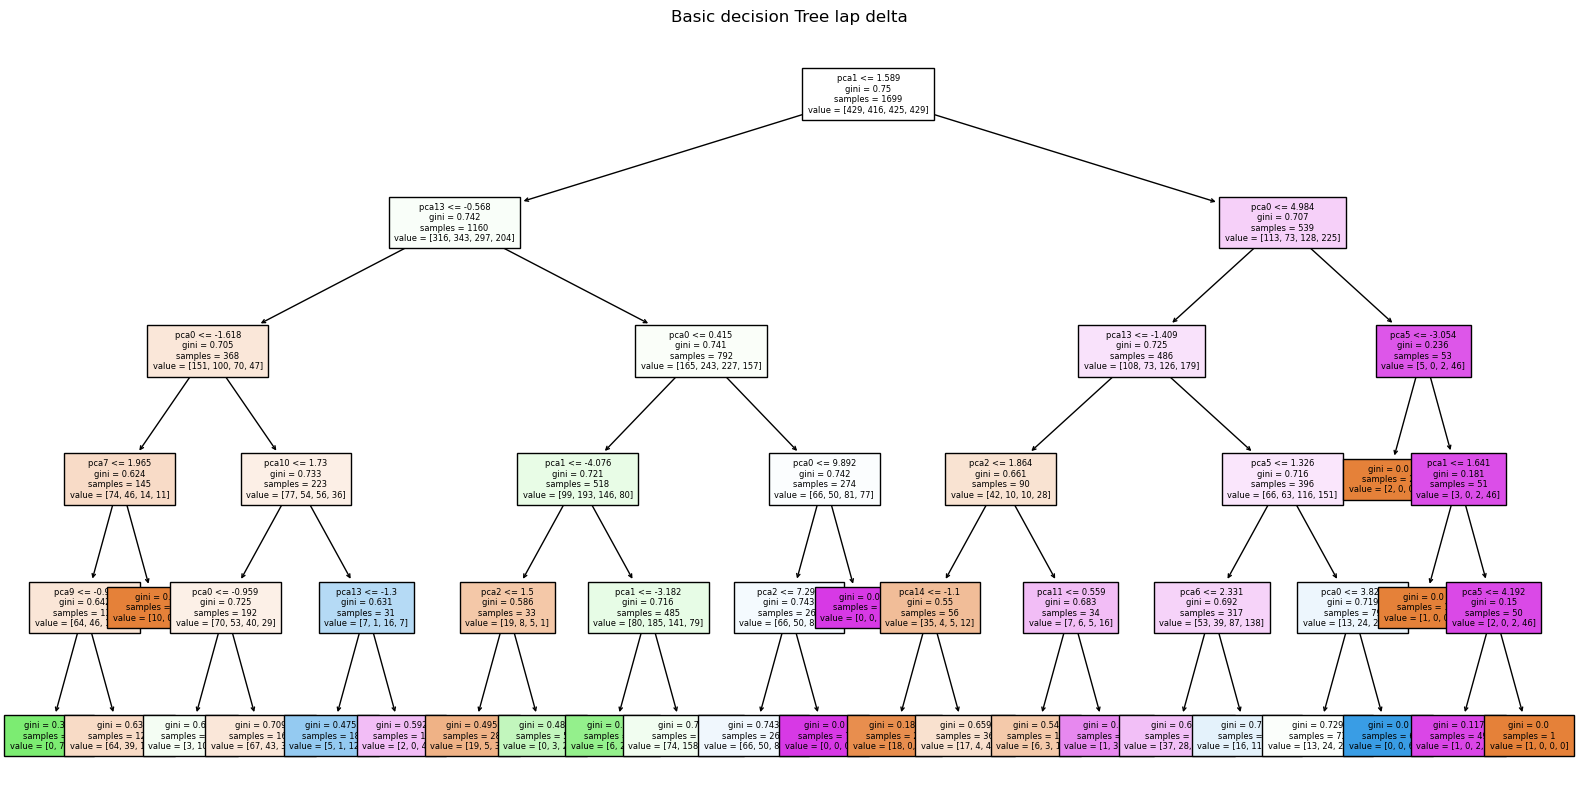

In [61]:
plt.figure(figsize=(20,10))

plot_tree(dt_model_delta.named_steps['decision_tree'],feature_names=dt_model_delta[:-1].get_feature_names_out(),filled=True, fontsize=6)
plt.title('Basic decision Tree lap delta')
plt.show()